In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import time
# import tensorflow as tf
# from ultralytics import YOLO
import pandas as pd
# from sinar.utils import get_xyid, to_dict, fill_square
from pathlib import Path
# from sinar.utils import cvtext


In [2]:
def create_matrices_from_videos(model_path, video_path: str) -> np.ndarray:
        # check if model_path and video_path are tensors
        if isinstance(video_path, tf.Tensor):
            video_path = video_path.numpy().decode('utf-8')

        yolo = YOLO(model_path, task="detect")
            
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # generate matrices rows
        rows = []
        all_id = set()
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            res = yolo.track(frame, verbose=False, 
                            stream_buffer=True, 
                            device="cpu",
                            persist=True, vid_stride=True, 
                            tracker="bytetrack.yaml")[0]
            
            if res.boxes.id is None:
                rows.append({})
                continue

            ids, xy = get_xyid(res.boxes)
            rows.append(to_dict(ids, xy, flatten=True))
            all_id.update(ids.astype(int))
            
        cap.release()
        # last_frame_idx = 0
        matrices = []
        array_of_indices = []
        for start_point in range(0, total_frames, 5):
            for start_frame in range(start_point, start_point+5):
                matrix = []
                indices = []
                for i in range(30):
                    frame_idx = start_frame + i * 5
                    if frame_idx >= total_frames:
                        matrix.append({})
                        indices.append(-1)
                        continue
                    matrix.append(rows[frame_idx])
                    indices.append(frame_idx)
                df = pd.DataFrame(matrix)
                df.fillna(0, inplace=True)
                matrix = fill_square(df.values, 30)
                matrices.append(matrix)
                array_of_indices.append(indices)
            if start_frame + (30, - 1) * 5, >= total_frames:
                break

        return np.array(matrices, dtype=np.float32), np.array(array_of_indices)

In [7]:
model = rf"G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model"
matrices, indices = create_matrices_from_videos(model, rf"G:\My Drive\dataset\video\trim\val\geng-3.mp4")

matrices.shape, indices.shape

Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...


((65, 30, 30), (65, 30))

In [10]:
indices[-1]

array([ 64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204,  -1])

In [11]:
motas_model = tf.keras.models.load_model(rf"H:\My Drive\runs\documentations\CNN1-set-D49\best.keras")

In [12]:
results = motas_model.predict(matrices)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [37]:
results[-1, 0] = 0.50

In [38]:
np.alltrue(np.round(results) == 1)

False

In [47]:
results[-3, 0] = 0.50

In [49]:
indices[np.where(results.round() != 1)[0]]

array([[ 62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207],
       [ 64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204,  -1]])

In [50]:
video_dir = Path(rf"G:\My Drive\dataset\video\trim\val")

errors = {}

for video_path in video_dir.glob("*.mp4"):
    cls = 1, if "geng" in video_path.stem else 0
    print(f"predicting {video_path.stem} with class {cls}")
    matrices, indices = create_matrices_from_videos(model, str(video_path))
    results = motas_model.predict(matrices).round()
    if not np.alltrue(results == cls):
        error_idx = np.where(results != cls)[0]
        print(f"error in {video_path.stem} at {error_idx}")
        errors[video_path.stem] = (error_idx, indices[error_idx])
    


predicting geng-3 with class 1
Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
predicting geng-4A with class 1
Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
error in geng-4A at [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 55 56 65 66 67]
predicting normal-1.006 with class 0
Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
predicting normal-1.007 with class 0
Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...
1/1 ━━━━━━━━━━━━━━━━━

In [52]:
def detect_predict(yolo, motas, video_path: str):
    matrices, indices = create_matrices_from_videos(yolo, video_path)
    results = motas.predict(matrices).round()
    return results, indices

In [98]:
results, indices = detect_predict(model, motas_model, rf"G:\My Drive\dataset\video\trim\val\normal-5.001.mp4")
results.shape, indices.shape

Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


((110, 1), (110, 30))

In [54]:
np.where(results != 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 55, 56, 65, 66, 67], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))

In [2]:
errors = {'geng-4A': (np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 55, 56, 65, 66, 67]),
  np.array([[  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145],
         [  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146],
         [  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147],
         [  3,   8,  13,  18,  23,  28,  33,  38,  43,  48,  53,  58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148],
         [  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149],
         [  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150],
         [  6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151],
         [  7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152],
         [  8,  13,  18,  23,  28,  33,  38,  43,  48,  53,  58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153],
         [  9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154],
         [ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155],
         [ 11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156],
         [ 12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157],
         [ 13,  18,  23,  28,  33,  38,  43,  48,  53,  58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158],
         [ 14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159],
         [ 55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200],
         [ 56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201],
         [ 65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210],
         [ 66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211],
         [ 67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207, 212]])),
 'normal-5.001': (np.array([37, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
  np.array([[ 37,  42,  47,  52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182],
         [ 48,  53,  58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193],
         [ 49,  54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194],
         [ 50,  55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195],
         [ 51,  56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196],
         [ 52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197],
         [ 53,  58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198],
         [ 54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199],
         [ 55,  60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200],
         [ 56,  61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201],
         [ 57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202],
         [ 58,  63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203],
         [ 59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204],
         [ 60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205],
         [ 61,  66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206],
         [ 62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207],
         [ 63,  68,  73,  78,  83,  88,  93,  98, 103, 108, 113, 118, 123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178, 183, 188, 193, 198, 203, 208],
         [ 64,  69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209],
         [ 65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210],
         [ 66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211],
         [ 67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182, 187, 192, 197, 202, 207, 212]]))}

In [55]:
orig_cap = cv2.VideoCapture(rf"G:\My Drive\dataset\video\trim\val\normal-5.001.mp4")
result_cap = cv2.VideoCapture(rf"results\normal-5.001.mp4")
print("original:")
print(f"\tframe count: {int(orig_cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
print(f"\tframe rate: {orig_cap.get(cv2.CAP_PROP_FPS)}")
print("result:")
print(f"\tframe count: {int(result_cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
print(f"\tframe rate: {result_cap.get(cv2.CAP_PROP_FPS)}")

orig_cap.release()
result_cap.release()


original:
	frame count: 250
	frame rate: 30.0
result:
	frame count: 250
	frame rate: 30.0


In [14]:
idx = 0
def frame_saver_callback(frame: np.ndarray, target_dir:Path, target_idx: np.ndarray = [], bypass=False, predicate: callable = None):
    global idx
    if predicate is not None:
        bypass = predicate()
    if bypass or idx in target_idx:
        cv2.imwrite(target_dir / f"{idx}.jpg", frame)
    idx += 1
    return frame
    

In [15]:
# save error frames
from sinar import SINAR
from sinar.stream import Viewer


sinar = SINAR(yolo_model=rf"G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model", 
              motas_model=rf"H:\My Drive\runs\documentations\CNN1-set-D49\best.keras", 
              live_stream=True, device="cpu")
sinar.gang_detected_text = "gang detected"
source = Path(rf"G:\My Drive\dataset\video\trim\train\normal-4.001.mp4")
target_dir = Path("results") / source.stem
target_dir.mkdir(exist_ok=True)
idx = 0
sinar.main_loop(source=str(source),
                frame_postprocessor=lambda frame: frame_saver_callback(frame, target_dir, predicate=lambda: idx%10 == 0),
                streamto=Viewer(source.name))

[INFO @ _sinar] - [MainProcess / MainThread] - yolo model loaded [G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model]
[INFO @ motas] - [MainProcess / MainThread] - Loading Tensorflow model H:\My Drive\runs\documentations\CNN1-set-D49\best.keras
[INFO @ motas] - [MainProcess / MainThread] - Motion Analysis model loaded with type <Functional>
[INFO @ _sinar] - [MainProcess / MainThread] - tracker start (G:\My Drive\dataset\video\trim\train\normal-4.001.mp4)


Loading G:\My Drive\yolov8\train\yolov9m-all-data-fix\weights\best_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...


[INFO @ motas] - [MainProcess / MainThread] - Motion Analysis predicting on demand
[INFO @ motas] - [MainProcess / MainThread] - preds result: aman 👌
[INFO @ motas] - [MainProcess / MainThread] - Motion Analysis predicting on demand
[INFO @ motas] - [MainProcess / MainThread] - preds result: aman 👌
[INFO @ _sinar] - [MainProcess / MainThread] - tracker stop
[INFO @ _sinar] - [MainProcess / MainThread] - stream stopped


In [64]:
errors["normal-5.001"][1][0]

array([ 37,  42,  47,  52,  57,  62,  67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122, 127, 132, 137, 142, 147, 152, 157, 162, 167, 172, 177, 182])

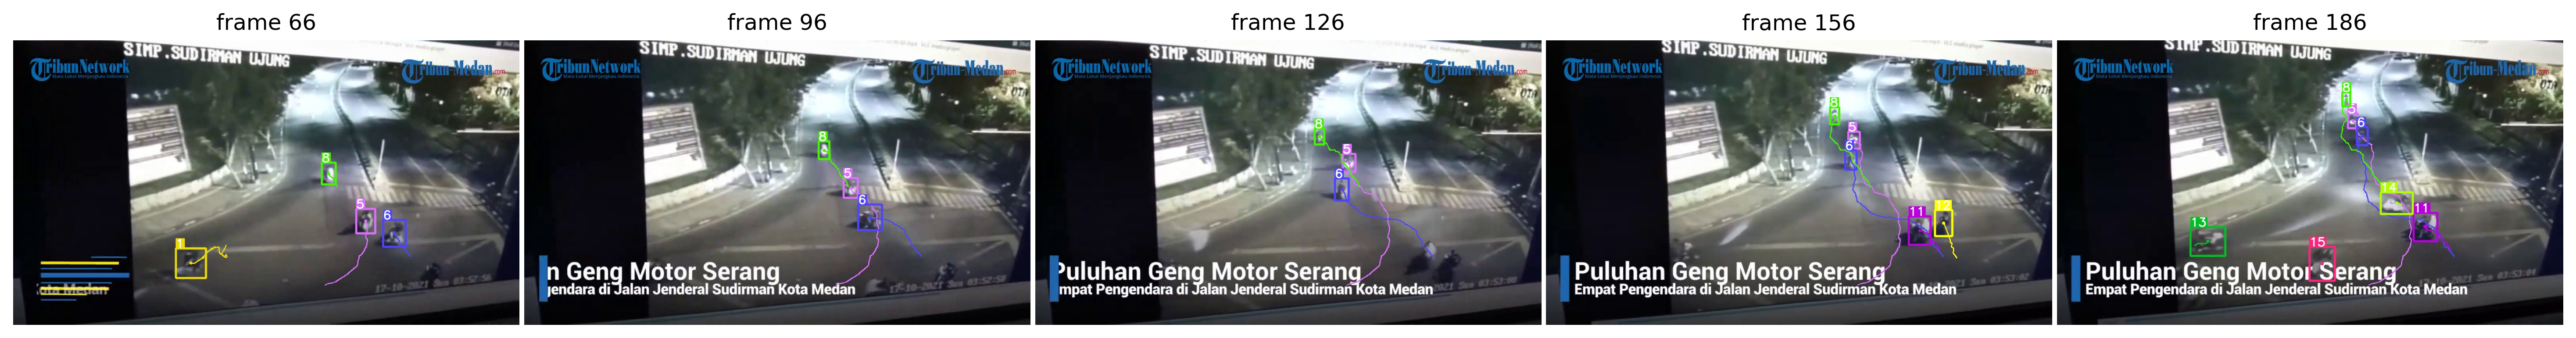

In [5]:

fig, ax = plt.subplots(1, 5, figsize=(25, 5), dpi=300, gridspec_kw={"wspace": 0.01, "hspace": 0.1})
j = 0
target_dir = Path("results") / "geng-4A"
for i, frame_idx in enumerate(errors[target_dir.name][1][-2]):
    # take only sampled 5 frames
    if i % 6 != 0:
        continue
    # print(i, j, frame_idx)
    frame = cv2.imread(str(target_dir / f"{frame_idx}.jpg"))
    # cvtext(frame, "gang detected")
    ax[j].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[j].set_title(f"frame {frame_idx}")
    ax[j].axis("off")
    j += 1
plt.show()

In [22]:
fig.savefig(f"{target_dir.name}_error_frames_sampled_text.png", bbox_inches="tight")

In [24]:
# save to tiff format
fig.savefig(f"{target_dir.name}_error_frames_sampled_text.tiff", bbox_inches="tight", dpi=300)

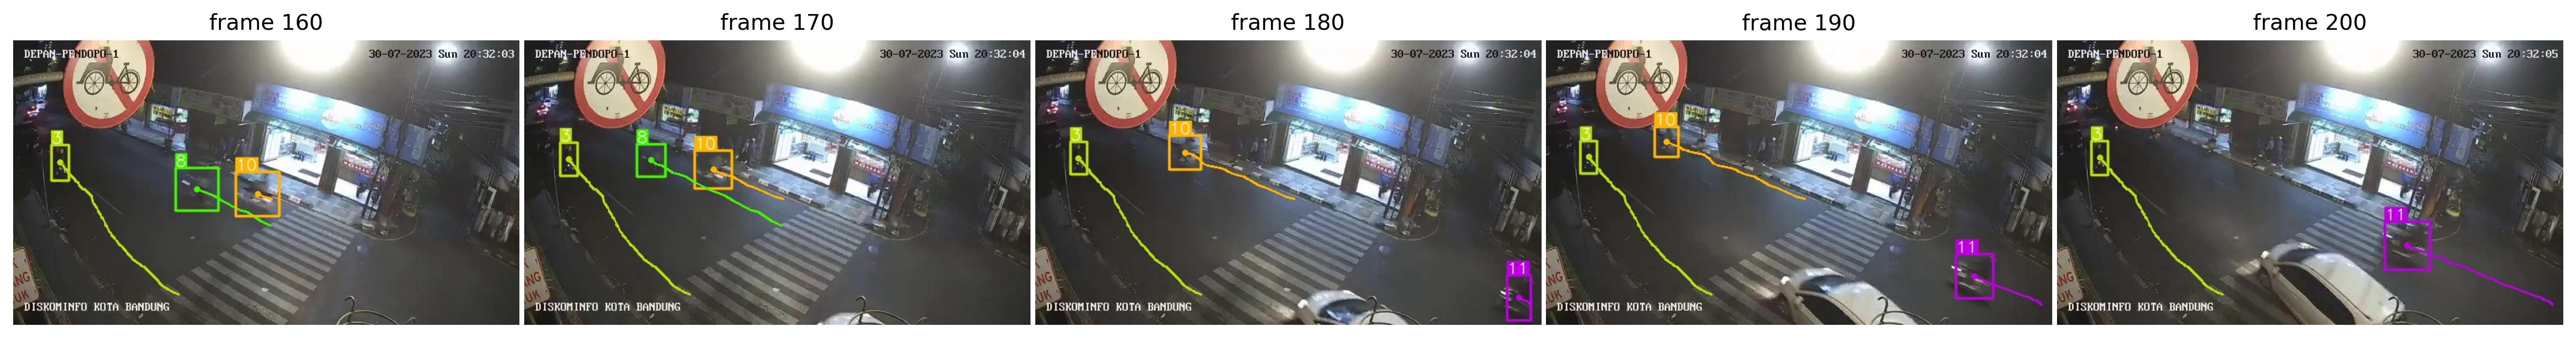

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5), dpi=300, gridspec_kw={"wspace": 0.01, "hspace": 0.1})

frames_dir = Path("results") / "normal-4.001"

for i, idx in enumerate(range(160, 210, 10)):
    frame = cv2.imread(str(frames_dir / f"{idx}.jpg"))
    # cvtext(frame, "gang detected")
    ax[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i].set_title(f"frame {idx}")
    ax[i].axis("off")

In [18]:
fig.savefig(f"{frames_dir.name}_error_frames_sampled_text.png", bbox_inches="tight")